# CSE 5520 Homework 7

"Visualization of GMM and EM"

| | |
|-|-|
| **Student** | Lynn Pepin ('Tristan Pepin')
|              | tmp13009 / 2079724
| **Due date** | 2021 / Oct / 30 (Sun), 11:59PM
| | ('Sun' should be 'Sat', per HuskyCT due date)

This homework is to help you practice with some data visualization fundamentals.
You are expected to use these visualization techniques and others in your final project.
You are required to do this exercise in Python.

All plots/graphs must have titles and x-y coordinate tick labels. 

In [42]:
# Common imports from Python standard libraries
from dataclasses import dataclass
import math

# Common imports from
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors
from scipy import stats
from scipy import cluster
from statistics import mean
from sklearn.neighbors import KernelDensity
import sklearn.metrics
from scipy.stats import gaussian_kde
import time

# Useful imports for visualization
import seaborn

# Other packages
import networkx as nx
import pyvis as pv

# Used for Part 1
import dash
from dash import dcc
from dash import html
from dash.dependencies import Input, Output
import plotly.express as px
import plotly.graph_objects as go

# Constants
EPS = 0.0000001
FINAL = False

# Some useful functions
def almost_equal(a,b,eps=EPS):
    return abs(a-b) <= eps

# Code provided from HW4
def stdev(X):
    m = mean(X)
    return math.sqrt(sum((x-m)**2 for x in X) / len(X))

def degreesOfFreedom(X, Y):
    s1 = (stdev(X)**2)
    s2 = (stdev(Y)**2)
    df = (s1 / len(X) + s2 / len(Y))**2 / ((s1 / len(X))**2 / (len(X) - 1) + (s2 / len(Y))**2 /
(len(Y) - 1))
    return(df)

# Part 1: K-means and GMM

You need to use your own data to do the problems and you can include your solution or its extended version as part of your proposal/final presentation.


In [2]:
df = pd.read_csv("../DATASETS/US_Accidents_Dec20_updated.csv")

## Step 1.

Prepare a 2D data from your project and plot it, i.e. as a scatter plot.

You can visually inspect and determine k, the number of clusters.

Text(0, 0.5, 'Latitude')

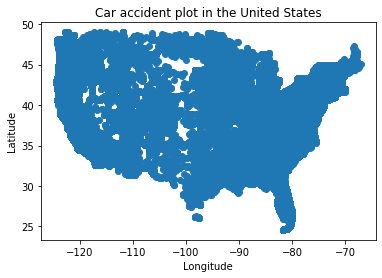

In [5]:
if not FINAL:
    plt.scatter(df["Start_Lng"], df["Start_Lat"])#, s=0.05, alpha=0.05)

    plt.title("Car accident plot in the United States")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")

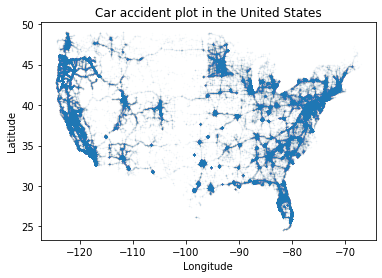

In [9]:
if not FINAL:
    plt.scatter(df["Start_Lng"], df["Start_Lat"], s=0.05, alpha=0.05)

    plt.title("Car accident plot in the United States")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")

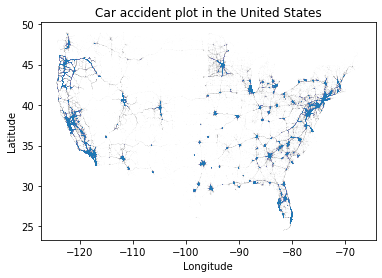

In [10]:
if not FINAL:
    plt.scatter(df["Start_Lng"], df["Start_Lat"], s=0.01, alpha=0.01)

    plt.title("Car accident plot in the United States")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")

From visual inspection, I am comfortable saying there are 13 main clusters. However, there are many smaller concentrated dots, but these are difficult to count (seem to be ~100).

## Step 2.

With your chosen $k$, perform the k-means clustering on your data.
Plot clustering result so that each color has different color,
for example, cluster 1 in red, cluster 2 in blue, etc.

You can plot with different $k$ to find a better number of clusters.

**(Extra credit):** You can use silhouette method or elbow method to find the optimum k.


In [59]:
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans

data = np.array([df["Start_Lng"], df["Start_Lat"]]).T

def get_sample(array, n_samples = 15161):
    indices = np.random.choice(list(range(len(array))), size=n_samples)
    return array[indices]


FI = (1 + 5**.5)/2 # golden ratio

# get hues, per an old favorite
# https://gamedev.stackexchange.com/questions/46463/how-can-i-find-an-optimum-set-of-colors-for-10-players
get_hues = lambda ii : colors.hsv_to_rgb(
    (
    (FI * ii) % 1,   # hue
    1.0,
    0.5
    )
)

# Precompute hues for convenience
hues = [get_hues(ii) for ii in range(300)]

# get_hues generates an RGB tuple for a given value (ii)
# using the equidistribution theorem,
# (FI % i) % 1
# will be equally distributed across [0,1),
# for any irrational FI.
# Per ~hash magic~, FI works best for maximum distinguishability.

In [22]:
np.array([df["Start_Lng"],df["Start_Lat"]])

array([[ -83.09286,  -84.0628 ,  -84.52468, ..., -117.84779, -118.40302,
        -117.23092],
       [  40.10891,   39.86542,   39.10266, ...,   33.77545,   33.99246,
          34.13393]])

In [151]:
data.shape

(1516064, 2)

In [152]:
# Sample our data to get a subset
some_data = get_sample(data)
print(some_data.shape)

(15161, 2)


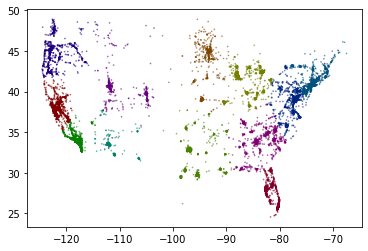

In [157]:
# for k = 12
K_CLUSTERS = 12

model = KMeans(n_clusters = K_CLUSTERS)
model.fit(some_data)
labels = model.predict(some_data)

rgb_colors = [hues[index] for index in labels]

plt.scatter(
    some_data[:,0],
    some_data[:,1],
    c=rgb_colors,
    s=0.5,
    alpha=0.5
)

In [159]:
MAX_K_TO_TEST = 30
GMMs = [None for _ in range(MAX_K_TO_TEST)]
scores = np.zeros(MAX_K_TO_TEST)
times = np.zeros(MAX_K_TO_TEST)


print("ii\tscore\ttime")
for ii in range(2,MAX_K_TO_TEST):
    start = time.time()
    gmm = GaussianMixture(n_components = ii + 1)
    gmm.fit(some_data)
    GMMs[ii] = gmm
    
    labels = gmm.predict(some_data)
    score = sklearn.metrics.silhouette_score(some_data, labels)
    scores[ii] = score
    
    total_time = time.time() - start
    print(f"{ii}\t{score:.3f}\t{total_time:.1f}s")
    times[ii] = time.time() - start


ii	score	time
2	0.545	2.1s
3	0.360	1.9s
4	0.398	2.2s
5	0.466	2.0s
6	0.474	1.9s
7	0.423	2.1s
8	0.485	2.1s
9	0.501	2.1s
10	0.535	2.2s
11	0.499	2.1s
12	0.522	2.1s
13	0.499	2.3s
14	0.400	2.4s
15	0.534	2.1s
16	0.541	2.5s
17	0.511	2.1s
18	0.552	2.4s
19	0.457	2.8s
20	0.503	2.6s
21	0.489	2.7s
22	0.442	3.1s
23	0.490	3.1s
24	0.547	2.7s
25	0.509	3.0s
26	0.561	2.6s
27	0.567	3.0s
28	0.535	2.4s
29	0.507	2.9s


In [160]:
print(np.round(scores,3))

[0.    0.    0.545 0.36  0.398 0.466 0.474 0.423 0.485 0.501 0.535 0.499
 0.522 0.499 0.4   0.534 0.541 0.511 0.552 0.457 0.503 0.489 0.442 0.49
 0.547 0.509 0.561 0.567 0.535 0.507]


In [162]:
print(scores.argsort()[::-1][:20])
print(scores[scores.argsort()[::-1][:20]])


[27 26 18 24  2 16 28 10 15 12 17 25 29 20  9 11 13 23 21  8]
[0.56666345 0.56070569 0.55180688 0.54663386 0.54491404 0.54104785
 0.53515291 0.53498633 0.53439647 0.52231263 0.51099819 0.50913957
 0.50718907 0.5033482  0.5010599  0.49922156 0.49916491 0.48972341
 0.48917962 0.4850962 ]


In [163]:
scores[10]
# Let's go with **ten**! It's very close to the highest score,
# but much easier to discern than 27 or 26.

0.534986334803662

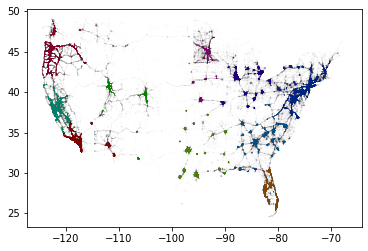

In [167]:
# for k = 10
K_CLUSTERS = 10

model = KMeans(n_clusters = K_CLUSTERS)
model.fit(some_data)
labels = model.predict(data)

rgb_colors = [hues[index] for index in labels]

plt.scatter(
    data[:,0],
    data[:,1],
    c=rgb_colors,
    s=0.02,
    alpha=0.02
)

## Step 3.

Calculate the centroid (mean of x axis, mean of y axis) of each cluster
and radii that covers 90 % of data of the cluster. 

In [175]:
# Step 3: Calculate the centroid (mean of x axis, mean of y axis) of each cluster and radii that covers 90 % of data of the cluster.
n_samp = len(data)

Xcen  = np.zeros(10)
Ycen  = np.zeros(10)

distances = []

for label in range(10):
    Xs = data[labels == label][:,0]
    Ys = data[labels == label][:,1]
    
    # get the center
    Xcen[label] = Xs.mean()
    Ycen[label] = Ys.mean()
    
    # sort these, and get the distance at the 90th index
    distance = ((Xs - Xs.mean())**2 + (Ys - Ys.mean())**2)**.5
    index_marking_90percent = int(len(distance) * .9)
    
    distances.append(np.sort(distance)[index_marking_90percent+1])

# Xs, Ys, distances    
distances

[3.1425357459201475,
 4.159369446526908,
 5.322610172670634,
 4.665705978303384,
 2.18963344900745,
 2.101325160756957,
 4.4051242829410455,
 5.746681306816127,
 3.6729034929931963,
 4.435496955799215]

## Step 4.

Plot the circles centered at the centroid with radius calculated in Step 3
on top of the plot created from Step 2.
Mark the centroid with ‘X’.

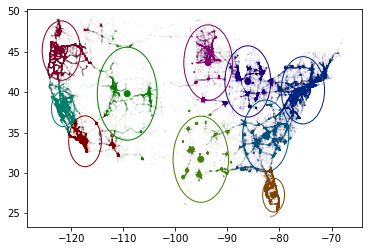

In [178]:
# Step 4: Plot with radiuses

plt.scatter(Xcen, Ycen, c=hues[:10])

# https://stackoverflow.com/questions/9215658/plot-a-circle-with-pyplot
for ii in range(10):
    circle = plt.Circle((Xcen[ii], Ycen[ii]), distances[ii], fill=False, color=hues[ii])
    plt.gca().add_patch(circle)
    

plt.scatter(
    data[:,0],
    data[:,1],
    c=rgb_colors,
    s=0.04,
    alpha=0.04
)

## Step 5.

In a markdown cell, discuss the goodness of your chosen $k$,
i.e., if you think what you have is the best or close to the best.

I think this is an appropriate size for analysis and for human understanding. This value of $k=10$ was chosen using silhouette method, and while not the best, is still very good for human understanding.

## Step 6.

Repeat steps 2 ~ 5, using GMM with the EM clustering method.
In this case, calculate covariance matrix for each cluster instead of radius.
Show the values.

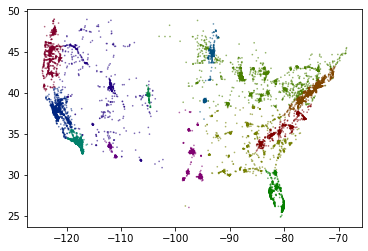

In [61]:
# for k = 13
K_CLUSTERS = 13

gmm = GaussianMixture(n_components = K_CLUSTERS)
gmm.fit(some_data)
labels = gmm.predict(some_data)

rgb_colors = [get_hues(index) for index in labels]

plt.scatter(
    some_data[:,0],
    some_data[:,1],
    c=rgb_colors,
    s=0.5,
    alpha=0.5
)

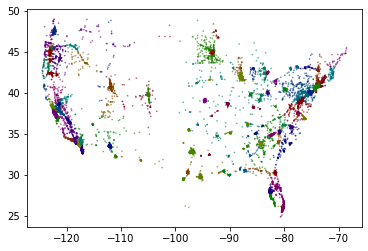

In [62]:
# for k = 100
K_CLUSTERS = 100

gmm = GaussianMixture(n_components = K_CLUSTERS)
gmm.fit(some_data)
labels = gmm.predict(some_data)

rgb_colors = [get_hues(index) for index in labels]

plt.scatter(
    some_data[:,0],
    some_data[:,1],
    c=rgb_colors,
    s=0.5,
    alpha=0.5
)

In [64]:
# Let's get the silhouette score

# e.g. k = 10
gmm = GaussianMixture(n_components=10)
gmm.fit(some_data)
labels = gmm.predict(some_data)

score = sklearn.metrics.silhouette_score(some_data, labels)
score

0.4665038168542998

In [180]:
MAX_K_TO_TEST = 20
GMMs = [None for _ in range(MAX_K_TO_TEST)]
scores = np.zeros(MAX_K_TO_TEST)
times = np.zeros(MAX_K_TO_TEST)


print("ii\tscore\ttime")
for ii in range(2,MAX_K_TO_TEST):
    start = time.time()
    gmm = GaussianMixture(n_components = ii + 1)
    gmm.fit(some_data)
    GMMs[ii] = gmm
    
    labels = gmm.predict(some_data)
    score = sklearn.metrics.silhouette_score(some_data, labels)
    scores[ii] = score
    
    total_time = time.time() - start
    print(f"{ii}\t{score:.3f}\t{total_time:.1f}s")
    times[ii] = time.time() - start

ii	score	time
2	0.457	2.2s
3	0.434	2.0s
4	0.450	1.9s
5	0.432	2.0s
6	0.433	2.2s
7	0.468	2.2s
8	0.456	2.2s
9	0.498	2.6s
10	0.512	2.4s
11	0.522	2.2s
12	0.522	2.4s
13	0.507	2.2s
14	0.516	2.2s
15	0.521	2.9s
16	0.499	2.3s
17	0.439	2.8s
18	0.442	2.8s
19	0.481	2.7s


In [181]:
scores.argsort()[::-1][:10]

array([11, 12, 15, 14, 10, 13, 16,  9, 19,  7])

In [182]:
scores[scores.argsort()[::-1][:10]]

array([0.52248605, 0.52234335, 0.52076288, 0.51618626, 0.512187  ,
       0.5074642 , 0.4990288 , 0.49847991, 0.48106864, 0.46828095])

... Per this, I'll choose **a value of $k = 12** for my clusters. The reason being:

1. It has a lower score than $11$ by only $0.00014$, while...
2. The number $12$ is easier to work with (since 11 is prime while 12 divides by 2, 3, 4, and 6.)

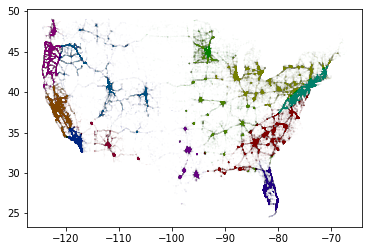

In [184]:
# for k = 12
K_CLUSTERS = 12

gmm = GaussianMixture(n_components = K_CLUSTERS)
gmm.fit(some_data)
labels = gmm.predict(data)

rgb_colors = [hues[index] for index in labels]

plt.scatter(
    data[:,0],
    data[:,1],
    c=rgb_colors,
    s=0.03,
    alpha=0.03
)

In [193]:
# Step 3: Calculate the covariance of each cluster
for label in range(12):
    print(
        np.cov(
            np.cov(data[labels == label].T)
        )
    )

[[36.30750832 13.6103741 ]
 [13.6103741   5.10203789]]
[[ 0.08722233 -0.07587869]
 [-0.07587869  0.06601034]]
[[ 265.11715228 -304.59090961]
 [-304.59090961  349.94198383]]
[[ 0.00421956 -0.12617721]
 [-0.12617721  3.77306754]]
[[1.13352223 0.56537739]
 [0.56537739 0.28199852]]
[[ 0.49834015 -0.54186915]
 [-0.54186915  0.58920033]]
[[ 1.71677844 -2.88977214]
 [-2.88977214  4.86421709]]
[[ 0.00081463 -0.00069626]
 [-0.00069626  0.0005951 ]]
[[16.22310225 -8.24014177]
 [-8.24014177  4.18538546]]
[[ 582.10292756 -284.85408689]
 [-284.85408689  139.39433556]]
[[271.29784432 -10.69609249]
 [-10.69609249   0.42170034]]
[[ 1.38100698 -3.06659503]
 [-3.06659503  6.80952753]]


In [199]:
data[labels == 0][:,9]

array([-91.1564  , -90.942407, -91.16979 , ..., -86.7503  , -86.78025 ,
       -88.33966 ])

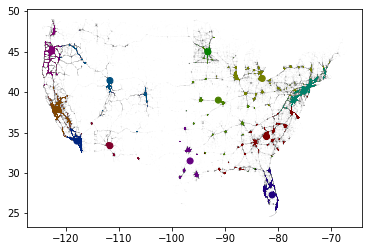

In [202]:
# Step 4: Plot
n_samp = len(data)

Xcen  = np.zeros(12)
Ycen  = np.zeros(12)

for label in range(12):
    Xcen[label] = data[labels == label][:,0].mean()
    Ycen[label] = data[labels == label][:,1].mean()

# Plot the centers
plt.scatter(Xcen, Ycen, c=hues[:12])

plt.scatter(
    data[:,0],
    data[:,1],
    c=rgb_colors,
    s=0.01,
    alpha=0.02
)

## Step 7.

Using a markdown cell, compare the outcomes from Step 6 with Step 4
and discuss which clustering method is better for your data.

Gaussian Mixture makes more sense for two reasons: One, the plot looks more "correct" to me, and because the added complexity might help account for the curvature of the Earth (as I am abusing lat-lon coordinates)

## Step 8 (Extra credit)

Plot 2D Gaussian curve calculated in Step 6
as shown in the 2D GMM with EM examples in the lecture slides.

# Part 2: K-means and GMM

This part is to continuously help you do the term project
by making you include visualization of k-means and GMM clustering methods in your Dashboard. 

Unfortunately, I have been unable to connect to the campus through VPN, and I have started this homework from home.

But, I self-host several Linux servers and publish my own webpages! I am very familiar with web-hosting, dealing with ports, Nginx reverse-proxy, etc.

So, do not worry! I can do this part... (Once I am on campus...)

# Step 1.

Publish the visualizations you have done in Part 1 to your Dashboard “privately” for now.

## Step 2.

Take a screenshot (screen clip) of your Dashboard and include it in a markdown cell
so that you succeeded in publishing your Part I plots in your Dashboard publication.

The URL should demonstrate that you can publish your Dashboard on the public VM.

You should kill your publication after you are done with the screenshot
since you do not make your Dashboard public yet.

You are only showing that you can publish Dashboard on a third party machine.